# [Custom Evaluators](https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/develop/evaluate-sdk#custom-evaluators)
Built-in evaluators are great out of the box to start evaluating your application's generations.<br/>
However, you might want to build your own code-based or prompt-based evaluator to cater to your specific evaluation needs.

## Environment prepration

In [11]:
# Constants and Libraries
import os, json
from azure.identity import DefaultAzureCredential, get_bearer_token_provider #requires azure-identity
from pprint import pprint
from dotenv import load_dotenv # requires python-dotenv

if not load_dotenv("./../../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
    
os.environ["AZURE_OPENAI_API_VERSION"] = os.environ["OPENAI_API_VERSION"]

credential = DefaultAzureCredential()

In [2]:
# Initialize Azure OpenAI connection

model_config = {
    "azure_endpoint": os.environ.get("AZURE_OPENAI_ENDPOINT"),
    "api_key": os.environ.get("AZURE_OPENAI_API_KEY"),
    "azure_deployment": os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    "api_version": os.environ.get("AZURE_OPENAI_API_VERSION"),
}

evaluator_localpath = "custom_evaluators/friendliness_evaluator"
evaluator_name = "FriendlinessEvaluator" # evaluator name to appear in the Evaluator library
evaluator_description = "prompt-based evaluator measuring response friendliness."

## Code-based evaluators
Sometimes a large language model isn't needed for certain evaluation metrics. This is when code-based evaluators can give you the flexibility to define metrics based on functions or callable class. You can build your own code-based evaluator, for example, by creating a simple Python class that calculates the length of an answer in `answer_length.py` under directory `custom_libraries`:
```
class AnswerLengthEvaluator:
    def __init__(self):
        pass
    # A class is made a callable my implementing the special method __call__
    def __call__(self, *, answer: str, **kwargs):
        return {"answer_length": len(answer)}
```

In [3]:
from custom_libraries.answer_length import AnswerLengthEvaluator

answer_length_evaluator = AnswerLengthEvaluator()
answer_length = answer_length_evaluator(answer="What is the speed of light?")

print(answer_length)

{'answer_length': 27}


## Prompt-based evaluators
To build your own prompt-based large language model evaluator or AI-assisted annotator, you can create a custom evaluator based on a Prompty file. Prompty is a file with .prompty extension for developing prompt template. The Prompty asset is a markdown file with a modified front matter. The front matter is in YAML format that contains many metadata fields that define model configuration and expected inputs of the Prompty. Let's create a custom evaluator FriendlinessEvaluator to measure friendliness of a response.
```
---
name: Friendliness Evaluator
description: Friendliness Evaluator to measure warmth and approachability of answers.
model:
  api: chat
  parameters:
    temperature: 0.1
    response_format: { "type": "text" }
inputs:
  response:
    type: string
outputs:
  score:
    type: int
  explanation:
    type: string
---

system:
Friendliness assesses the warmth and approachability of the answer. Rate the friendliness of the response between one to five stars using the following scale:

One star: the answer is unfriendly or hostile

Two stars: the answer is mostly unfriendly

Three stars: the answer is neutral

Four stars: the answer is mostly friendly

Five stars: the answer is very friendly

Please assign a rating between 1 and 5 based on the tone and demeanor of the response.

**Example 1**
generated_query: I just dont feel like helping you! Your questions are getting very annoying.
output:
{"score": 1, "reason": "The response is not warm and is resisting to be providing helpful information."}
**Example 2**
generated_query: I'm sorry this watch is not working for you. Very happy to assist you with a replacement.
output:
{"score": 5, "reason": "The response is warm and empathetic, offering a resolution with care."}


**Here the actual conversation to be scored:**
generated_query: {{response}}
output:
```

In [4]:
from custom_libraries.friend import FriendlinessEvaluator
from pprint import pprint
model_config["type"] = "AzureOpenAI"

friendliness_eval = FriendlinessEvaluator(model_config)

friendliness_score = friendliness_eval(response="I will not apologize for my behavior!")
pprint(friendliness_score)

{'reason': 'The response is mostly unfriendly, as it is defensive and lacks '
           'warmth or empathy.',
 'score': 2}


## [Convert evaluator to evaluation flow and save it locally](https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/develop/cloud-evaluation#specifying-evaluators-from-evaluator-library)
This format is needed to upload the evaluator to Azure

In [6]:
from promptflow.client import PFClient
from azure.ai.ml.entities import Model
import shutil

shutil.rmtree(evaluator_localpath, ignore_errors=True)

pf_client = PFClient()
pf_client.flows.save(entry=FriendlinessEvaluator, path=evaluator_localpath)

## Connect to Azure Machine Learning Platform

In [9]:
# Create ml_client to register custom evaluator

from azure.ai.ml import MLClient

ml_client = MLClient(
       subscription_id=os.environ["AZURE_SUBSCRIPTION_ID"],
       resource_group_name=os.environ["RESOURCE_GROUP_NAME"],
       workspace_name=os.environ["PROJECT_NAME"],
       credential=DefaultAzureCredential()
)

print(f"AI Foundry Project: {os.environ["PROJECT_NAME"]}")

AI Foundry Project: mmai-swc-hub01-prj01


## [Register the evaluator to the Evaluator library](https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/develop/cloud-evaluation#specifying-evaluators-from-evaluator-library), reading from local folder

In [10]:
custom_evaluator = Model(
    path=evaluator_localpath,
    name=evaluator_name,
    description=evaluator_description,
)
registered_evaluator = ml_client.evaluators.create_or_update(custom_evaluator)
print("Registered evaluator id:", registered_evaluator.id)

Method evaluators: This is an experimental method, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading friendliness_evaluator (0.0 MBs): 100%|██████████| 4560/4560 [00:00<00:00, 63664.08it/s]




Registered evaluator id: /subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourceGroups/mmai-swc-hub01-grp/providers/Microsoft.MachineLearningServices/workspaces/mmai-swc-hub01-prj01/models/FriendlinessEvaluator/versions/11


## Optional: Archive an evaluator
Evaluators, as models, cannot be "deleted", they can just be "archived"

In [ ]:
ml_client.models.archive(name=evaluator_name, version=8)

## [View registered Custom Evaluators](https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/develop/cloud-evaluation#specifying-evaluators-from-evaluator-library)
After registering your custom evaluator to your Azure AI project, you can view it in your Evaluator library under Evaluation tab in your Azure AI project.
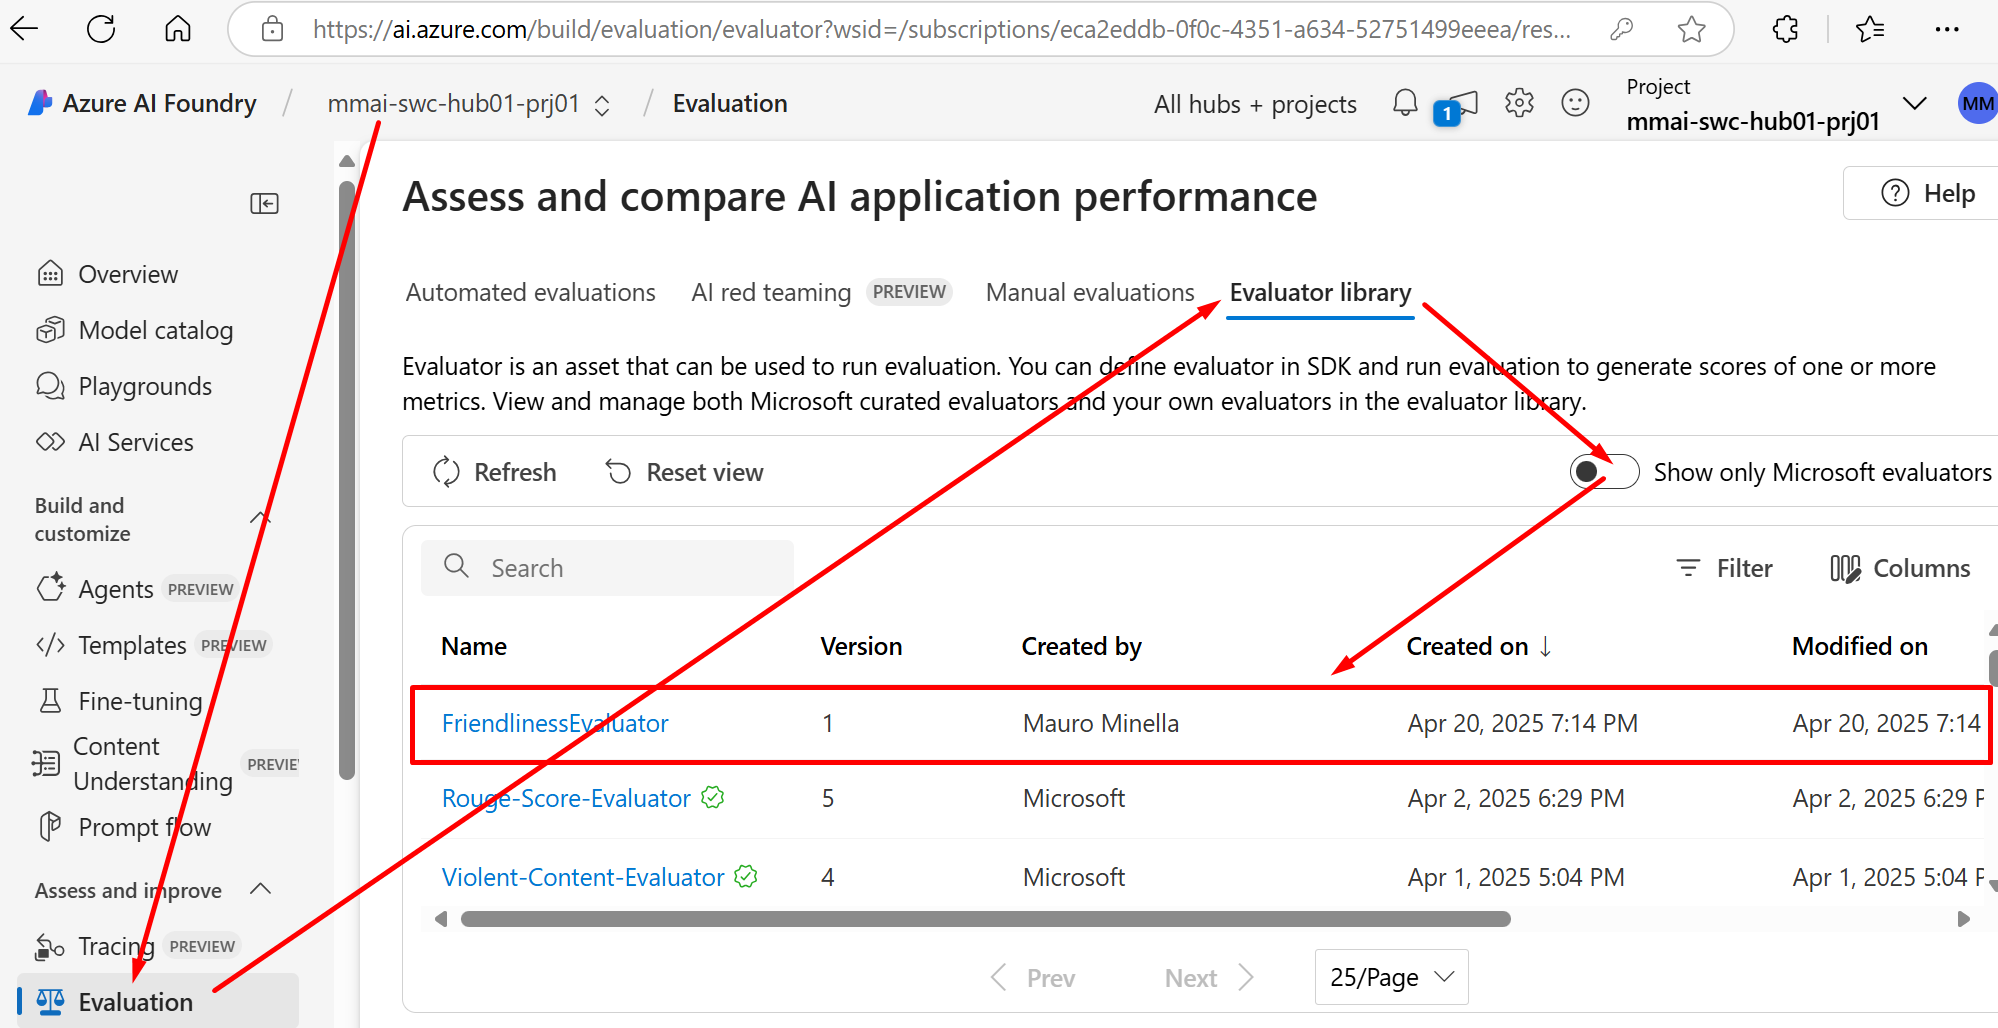

## We can also see the registered Custom Evaluators as `models` in Azure ML Studio, where the ML workspace is the AI Foundry project:
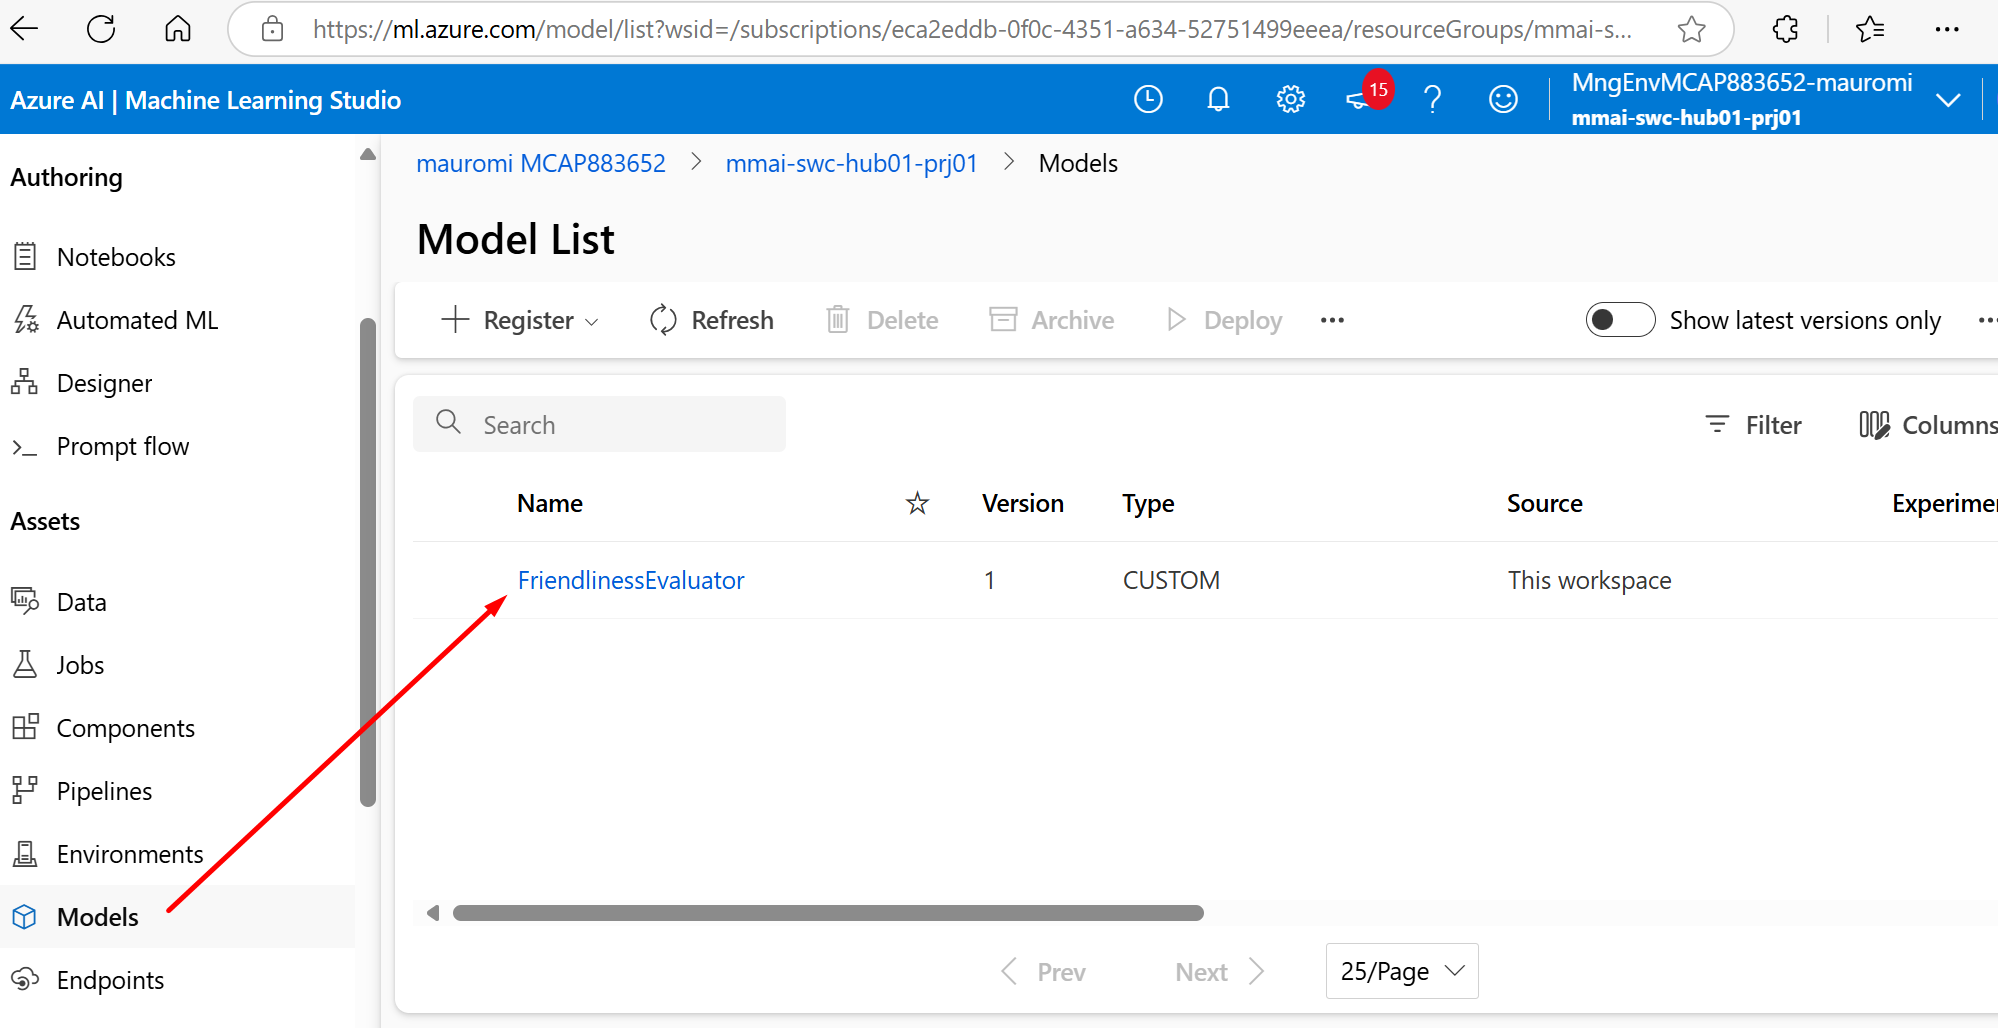

## Retrieve the evaluator
We can retrieve it of course but... for doing what? If we want to use it in the cloud, we need to deploy it!
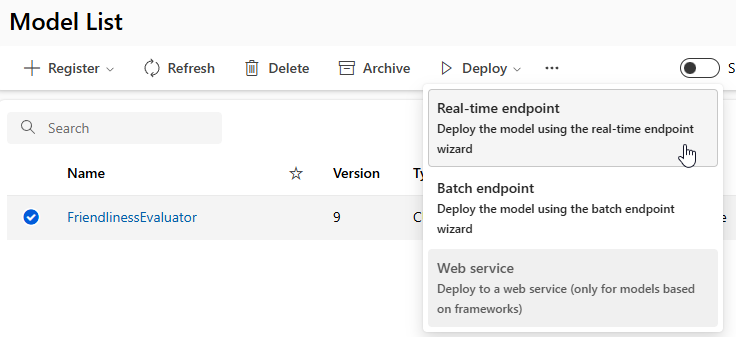

In [ ]:
my_friend_eval = ml_client.evaluators.get(evaluator_name, version=8)
my_friend_eval